# Implementation of NLU component of a chatbot

In this assignment you will build an application that performs __intent classification__ and __slot filling__, which are the core tasks that take care the **NLU module** in any chatbot. 

*   __intent classification__ consist in mapping user utterance (typically a 
customer) into a predefined set of _intents_ (goals of the user) so the computer can know what she is asking.

* __slot filling__ consist in extracting filler values from the uterance of the user. 

The example below show a user command asking a flight ticket to fly from Boston to Denver, departing at 8:38 and arriving at 11:10. The goal is to extrac all this information automatically. 

![](https://drive.google.com/uc?export=view&id=1cWS1ybRPMGladx3qv8G4th5fyZO3cA-h)


We will use the [ATIS (Airline Travel Information Systems) dataset](https://www.aclweb.org/anthology/H90-1021.pdf), which is  a dataset consisting of audio recordings and corresponding manual transcripts about humans asking for flight information on automated airline travel inquiry systems. The data consists of 17 unique intent categories, and 81 slots in total. 

The main goal of the assigment is to build a system that perform intent detection and slot filing. We define a list steps you can folllow to complete the assignemnt. The steps are the following:
- Preprocess the data.
- Implement the models for intent classification and slot filling.
- Evaluate proposed model.
- Run some analysis of the model output.

Note you are not requiered to strictly follow the steps suggested in the notebook as long as you build a model, evaluate it and provide some analysis.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/LAP/Subjects/AP2/assignments

/content/drive/MyDrive/LAP/Subjects/AP2/assignments


## Some utils
We provide some utilities that can be useful for the assignments. You are not obligated to use them, but depending on you model (e.g. CRF, LSTM, or BERT), it might be a good idea to use them. Also, it might faster to  

We provide two 


In [3]:
import pandas as pd

# helper function to read dev and test data format (use get_data2 for training)
def get_data(filename):
    df = pd.read_csv(filename, delim_whitespace=True, names=['word', 'label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents, labels, intents = [], [], []
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    return sents, labels, intents

# helper function to read training data format
def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents, labels, intents = [],[],[]
    for line in contents.strip().split('\n'):
        words, labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    return sents, labels, intents

## Load the data and understand it

First thing you need to do is to understand the different aspects of the your data, such as knowing how the information is formated, the number of examples we have to train, validate and test our models, what is the distribution of labels, and so on. 

### TO-DO
Using your own code or the one provided above load the data and run some small analysis. For example, it is a good idea to print some statistics: 

- Number of examples for each partition
- Class distribution for intent classification
- Class distribution for slot filling task. 
- Do we have same set of slot labels for each intent type? 

Additionally, it is also good idea to create some plots of the statistics. 

In [57]:
data_dir="../data/atis"
train_file= data_dir + '/atis.train.w-intent.iob'
dev_file= data_dir + '/atis-2.dev.w-intent.iob'
test_file= data_dir + '/atis.test.w-intent.iob'

train_texts, train_slots, train_intents = get_data2(train_file)
dev_texts, dev_slots, dev_intents = get_data(dev_file)
test_texts, test_slots, test_intents = get_data(test_file)

In [5]:
print(train_texts[0])
print(train_slots[0])
print(train_intents[0])

['i', 'want', 'to', 'fly', 'from', 'boston', 'at', '838', 'am', 'and', 'arrive', 'in', 'denver', 'at', '1110', 'in', 'the', 'morning']
['O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-depart_time.time', 'I-depart_time.time', 'O', 'O', 'O', 'B-toloc.city_name', 'O', 'B-arrive_time.time', 'O', 'O', 'B-arrive_time.period_of_day']
atis_flight


### Dataframe

In [10]:
train_df = pd.DataFrame({"text": train_texts, "slots": train_slots, "intent": train_intents})
train_df

,text,slots,intent
0,"[i, want, to, fly, from, boston, at, 838, am, ...","[O, O, O, O, O, O, B-fromloc.city_name, O, B-d...",atis_flight
1,"[what, flights, are, available, from, pittsbur...","[O, O, O, O, O, B-fromloc.city_name, O, B-tolo...",atis_flight
2,"[what, is, the, arrival, time, in, san, franci...","[O, O, O, B-flight_time, I-flight_time, O, B-f...",atis_flight_time
3,"[cheapest, airfare, from, tacoma, to, orlando]","[B-cost_relative, O, O, B-fromloc.city_name, O...",atis_airfare
4,"[round, trip, fares, from, pittsburgh, to, phi...","[B-round_trip, I-round_trip, O, O, B-fromloc.c...",atis_airfare
...,...,...,...
4973,"[what, is, the, airfare, for, flights, from, d...","[O, O, O, O, O, O, O, B-fromloc.city_name, O, ...",atis_airfare
4974,"[do, you, have, any, flights, from, denver, to...","[O, O, O, O, O, O, B-fromloc.city_name, O, B-t...",atis_flight
4975,"[which, airlines, fly, into, and, out, of, den...","[O, O, O, O, O, O, O, B-city_name]",atis_airline
4976,"[does, continental, fly, from, boston, to, san...","[O, B-airline_name, O, O, B-fromloc.city_name,...",atis_flight


In [55]:
dev_df = pd.DataFrame({"text": dev_texts, "slots": dev_slots, "intent": dev_intents})
dev_df

,text,slots,intent
0,"[i, want, to, fly, from, boston, at, 838, am, ...","[O, O, O, O, O, B-fromloc.city_name, O, B-depa...",atis_flight
1,"[show, me, all, round, trip, flights, between,...","[O, O, O, B-round_trip, I-round_trip, O, O, B-...",atis_flight
2,"[i, would, like, some, information, on, a, fli...","[O, O, O, O, O, O, O, O, O, B-fromloc.city_nam...",atis_flight
3,"[what, are, the, coach, flights, between, dall...","[O, O, O, B-class_type, O, O, B-fromloc.city_n...",atis_flight
4,"[i'm, flying, from, boston, to, the, bay, area]","[O, O, O, B-fromloc.city_name, O, O, B-toloc.c...",atis_flight
...,...,...,...
495,"[pm, flights, dallas, to, atlanta]","[B-depart_time.period_of_day, O, B-fromloc.cit...",atis_flight
496,"[information, on, flights, from, baltimore, to...","[O, O, O, O, B-fromloc.city_name, O, B-toloc.c...",atis_flight
497,"[what, flights, from, atlanta, to, st., louis,...","[O, O, O, B-fromloc.city_name, O, B-toloc.city...",atis_flight
498,"[show, me, ground, transportation, in, san, fr...","[O, O, O, O, O, B-city_name, I-city_name]",atis_ground_service


In [58]:
test_df = pd.DataFrame({"text": test_texts, "slots": test_slots, "intent": test_intents})
test_df

,text,slots,intent
0,"[i, would, like, to, find, a, flight, from, ch...","[O, O, O, O, O, O, O, O, B-fromloc.city_name, ...",atis_flight
1,"[on, april, first, i, need, a, ticket, from, t...","[O, B-depart_date.month_name, B-depart_date.da...",atis_airfare
2,"[on, april, first, i, need, a, flight, going, ...","[O, B-depart_date.month_name, B-depart_date.da...",atis_flight
3,"[i, would, like, a, flight, traveling, one, wa...","[O, O, O, O, O, O, B-round_trip, I-round_trip,...",atis_flight
4,"[i, would, like, a, flight, from, orlando, to,...","[O, O, O, O, O, O, B-fromloc.city_name, O, B-t...",atis_flight
...,...,...,...
888,"[please, find, all, the, flights, from, cincin...","[O, O, O, O, O, O, B-fromloc.city_name, O, O, ...",atis_flight
889,"[find, me, a, flight, from, cincinnati, to, an...","[O, O, O, O, O, B-fromloc.city_name, O, O, O, ...",atis_flight
890,"[i'd, like, to, fly, from, miami, to, chicago,...","[O, O, O, O, O, B-fromloc.city_name, O, B-tolo...",atis_flight
891,"[i, would, like, to, book, a, round, trip, fli...","[O, O, O, O, O, O, B-round_trip, I-round_trip,...",atis_flight


### Text distribution

In [42]:
train_text_df = pd.Series(sum([item for item in train_df["text"]], [])).value_counts()
train_text_df

to            4308
from          3716
flights       2433
the           2095
on            1495
              ... 
823              1
capacities       1
final            1
route            1
scenario         1
Length: 898, dtype: int64

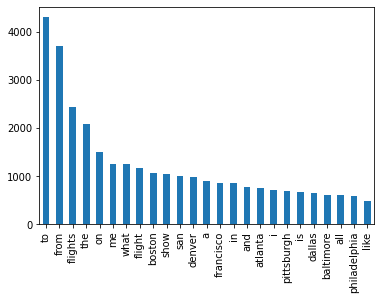

In [60]:
train_text_df[:25].plot.bar()

### Intent distribution

In [61]:
train_intent_df = train_df['intent'].value_counts()
train_intent_df

atis_flight                                 3666
atis_airfare                                 423
atis_ground_service                          255
atis_airline                                 157
atis_abbreviation                            147
atis_aircraft                                 81
atis_flight_time                              54
atis_quantity                                 51
atis_flight#atis_airfare                      21
atis_airport                                  20
atis_distance                                 20
atis_city                                     19
atis_ground_fare                              18
atis_capacity                                 16
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               6
atis_airline#atis_flight_no                    2
atis_ground_service#atis_ground_fare           1
atis_airfare#atis_flight_time                  1
atis_cheapest       

In [63]:
dev_intent_df = dev_df['intent'].value_counts()
dev_intent_df

atis_flight                      357
atis_airfare                      38
atis_ground_service               25
atis_airline                      18
atis_abbreviation                 17
atis_aircraft                     11
atis_quantity                     10
atis_flight_time                   9
atis_distance                      3
atis_ground_fare                   3
atis_airport                       3
atis_flight#atis_airfare           2
atis_restriction                   1
atis_capacity                      1
atis_city                          1
atis_airfare#atis_flight_time      1
Name: intent, dtype: int64

In [64]:
test_intent_df = test_df['intent'].value_counts()
test_intent_df

atis_flight                    632
atis_airfare                    48
atis_airline                    38
atis_ground_service             36
atis_abbreviation               33
atis_capacity                   21
atis_airport                    18
atis_flight#atis_airfare        12
atis_distance                   10
atis_aircraft                    9
atis_flight_no                   8
atis_ground_fare                 7
atis_city                        6
atis_meal                        6
atis_quantity                    3
atis_day_name                    2
atis_flight_time                 1
atis_airfare#atis_flight         1
atis_flight#atis_airline         1
atis_flight_no#atis_airline      1
Name: intent, dtype: int64

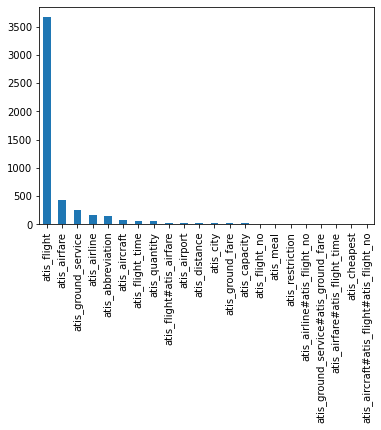

In [62]:
train_intent_df.plot.bar()

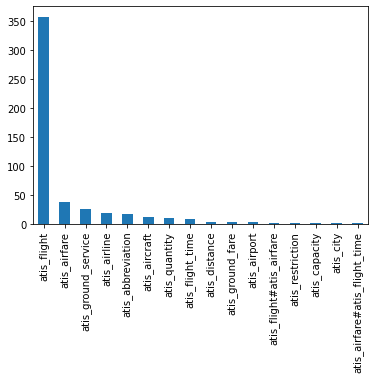

In [65]:
dev_intent_df.plot.bar()

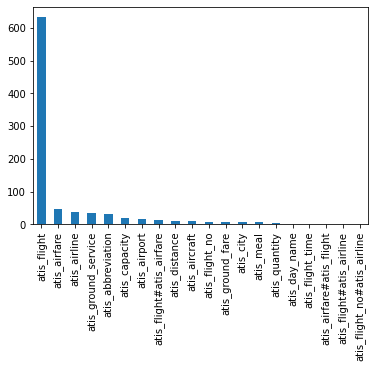

In [66]:
test_intent_df.plot.bar()

### Slots distribution

In [45]:
train_slots_df = pd.Series(sum([item for item in train_df["slots"]], []), name="slots").value_counts().to_frame()
train_slots_df

,slots
O,35670
B-toloc.city_name,4343
B-fromloc.city_name,4326
I-toloc.city_name,1099
B-depart_date.day_name,889
...,...
B-stoploc.airport_name,1
I-return_date.day_number,1
I-time,1
B-time_relative,1


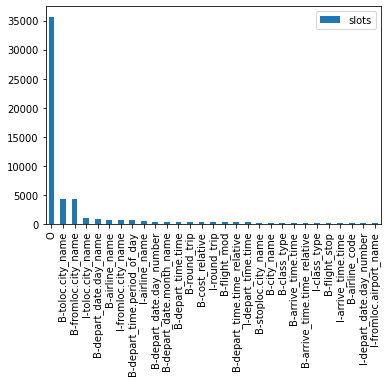

In [48]:
train_slots_df[train_slots_df["slots"] > 100].plot.bar()

## Preprocess

As we learn in class all the NLP task require some sort of preprocessing steps. The steps vary depending on the task as well as the type model we plan to use. That is, if our choice is to train a feature based ML model, then we probably would need more than tokenization (recall that based on the preprocessing we will build our set of features). As the goal of the assignment is not to exclusively focus on preprocessing, you can start tokenizating, lemmatizing and getting the PoS of each token. For this, you can any of the existing tool for NLP such as spaCy and NLTK.

On the contrary, if we plan to use DL for modeling our tasks, than preprocessing steps can be reduced to: 
- Tokenization
- Word indexing (and creation of the vocabulary)
- Converting text to sequence of word indexes (vectorization)
- Sequence padding if needed.

### TO-DO
- Preprare your data to feed your model.

In [ ]:
def preprocess_data(data_list):
    pass

## Build your models

Note that in to complete the assignment you have to be able to approach the two tasks, which typically they are approached in separated manner. _Intent classification_ can be cast as __text classification__, while _slot filling_ is usually approached as a __squence labeling__ task. 
The simplest solution is to create two models, where we learn each task separately. Optionaly, you can define a joint model in which both tasks are learned at the same time. 

The following code shows the set of methods that models should contain.

- `__init__`: You can use the initialization method (or constructor) to set the hyperparameters of the model.
- `fit`: Method that takes care of the training. Tipically it takes training and validation data as input.
- `predict`: Given the test data it returns the predictions of the model.

In the case you are using a Python library like `Scikit-learn` you really don't need to use the code snippets provided below. Then you can directly load your ML object. 

### TO-DO

- Generate the code to build the models that are able to approach the inten classification  and slot filling tasks.
- You can reused the code used in the other labs. 



In [ ]:
# Use this snippet code as a guide, and feel free to modify it as you want.

class text_classification_model(object):
    def __init__():
        pass

    def fit(train_data, val_data):
        pass

    def predict(test_data):
        pass


class sequence_labeling_model(object):
    def __init__():
        pass

    def fit(train_data, val_data):
        pass

    def predict(test_data):
        pass 

## Train, validate and evaluate

__Training__

Once you defined your model, and loaded and preprocessed the data, you just need to train it.  Depending on your model choice, you might need to extract the features (and vectorize the examples) before you fit your model. 

Be aware that in this phase we can explore and tune the hyperparameter values of our model. Note that we are not allowed to use the test partition for that. All the development of our approach is done on training and development paritions. 

__Evaluation__

Once you fit the model and you are happy with your results obtained in the validation part, you can move to evaluate the model on the test part. 
 Note that you have to choose a set of useful evaluation __metrics__. Typically, we use precision, recall, and f1-score, and you can use  For that you can use the functions in `sklearn.metrics` modules.  If you are using `tensorflow` or `pytorch` you can their buil-in metrics for the evaluation.

### TO-DO
- Fit and tune your model using the training and development partition.
- Make clear in the code how you tune your model. 
- Evaluate it on the test set.



## Analysis of the output
It is important to run some analysis of the output of our model in order to gain some insights about good and bad things of the model. A good idea is to extract some correct examples and incorrectly predicted examples. For the slot filing task you can use [the spaCy visualizer for entities](https://spacy.io/usage/visualizers). A example of how to use it you can find in the notebook of __lab 2 (NER with spaCy)__.

In addition, the calculation of a confusion matrix it is very helpful to depict the type of prediction error. It helps to see if there a bias towards a specific set of labels, or there exist some kind confusability between classes (e.g. because class definitions are similar) and so on.  You can find in `scikit-learn` a module to calculate confusion matrices (`sklearn.metrics.confusion_matrix`)

### TO-DO 
- Show some correct and incorrect examples for intent classification and slot filling. 
- Calculate on the development set and show the confusion matrix of your model. 
